# Amazon Review Sentiment
## Ivan Chavez, Uyen Pham, & Lane Whitmore
### ADS 509
### The University of San Diego
### Dr. Sadeghian

In [73]:
# Imports
import os
import pandas as pd
import seaborn as sns
# Custom Function imports
import sys
sys.path.append('C:/Users/whitm/Documents/GitHub/ads-509-final/functions')
import token_functions as tf
import data_loading as dl
#import functions.token_functions as tf
#import functions.data_loading as dl
import numpy as np
import spacy
import pickle
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.svm import LinearSVC
from sklearn.utils import resample
import matplotlib.pyplot as plt
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, SequentialSampler, DataLoader, RandomSampler
from tqdm import trange, notebook
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

In [4]:
# Extracting Stopwords from packages
nlp = spacy.load('en_core_web_sm')
sw = stopwords.words("english")

## Importing the Data

The data from Amazon has been scraped into a csv file of reviews for each product. Those files were stored in their respective folders; games, books, or movies for ease of use moving forward in the project. 

In [5]:
# Directories for each folder
games_dir = 'C:/Users/whitm/OneDrive/Desktop/ADS509/data/games'
books_dir = 'C:/Users/whitm/OneDrive/Desktop/ADS509/data/books'
movies_dir = 'C:/Users/whitm/OneDrive/Desktop/ADS509/data/movies'

In [6]:
# Importing each folder as a single pandas dataframe
games_df = dl.read_csv_files(games_dir)
books_df = dl.read_csv_files(books_dir)
movies_df = dl.read_csv_files(movies_dir)

In [7]:
# Creates a combined dataframe if needed for analysis
# Create an empty list to store the review dataframes
df_list = []

for root, dirs, files in os.walk('C:/Users/whitm/OneDrive/Desktop/ADS509/data'):
    for filename in files:
        # Read the CSV file into a datadrame
        df = pd.read_csv(os.path.join(root, filename), index_col=0)

        # Append the dataframe to the list
        df_list.append(df)

# Combine the dataframes into a single dataframe
combined_df = pd.concat(df_list, ignore_index=True)

## Exploratory Data Analysis

### Games Data Exploration

In [8]:
games_df.isna().sum()

name            0
game_title      0
review_title    0
review          3
rating          0
date_place      0
dtype: int64

In [9]:
# removing null values
games_df = games_df.dropna()
games_df.shape

(1417, 6)

In [10]:
games_df.head(3)

,name,game_title,review_title,review,rating,date_place
0,Steve Samuelson,"Anno 1800 - Standard Edition, Xbox Series X",City Building Game,I would compare this game to Tropico. It is a ...,4.0,"Reviewed in the United States 🇺🇸 on May 10, 2023"
1,Eric F. Brown,"Anno 1800 - Standard Edition, Xbox Series X",I love this,"I love games like this, the graphics are stunn...",5.0,"Reviewed in the United States 🇺🇸 on March 29, ..."
2,Grey Day,"Anno 1800 - Standard Edition, Xbox Series X",must create ubisoft account,You can't play unless you create an ubisoft ac...,1.0,"Reviewed in the United States 🇺🇸 on April 23, ..."


In [11]:
games_df['game_title'].unique()

array(['Anno 1800 - Standard Edition, Xbox Series X',
       'Dead Island 2: Day 1 Edition - Xbox Series X',
       'Dead Space - Xbox Series X',
       'Diablo IV - Ultimate Edition - Xbox [Digital Code]',
       'Dying Light 2 Stay Human - Xbox Series X',
       'EA SPORTS PGA Tour - Xbox Series X', 'Elden Ring - Xbox Series X',
       "Five Nights at Freddy's: Security Breach (XSX)",
       'Forza Horizon 5: Premium Edition – Xbox & Windows [Digital Code]',
       'Forza Horizon 5: Standard Edition – Xbox & Windows [Digital Code]',
       'Forza Horizon 5: Standard Edition – Xbox Series X & Xbox One',
       'Grand Theft Auto V - Xbox Series X',
       'Halo Infinite: Standard Edition – Xbox Series X & Xbox One',
       'Hogwarts Legacy: Digital Deluxe Edition - Xbox [Digital Code]',
       'Hogwarts Legacy: Standard Edition - Xbox Series X|S [Digital Code]',
       'Hogwarts Legacy - Xbox Series X | English | EU Import Region Free Version',
       'Just Dance 2022 (Xbox One/Series 

In [12]:
# Investigate different languages that make up the review text
games_df['lang'] = games_df['review'].apply(tf.detect_language)
games_df['lang'].value_counts()

en         1288
es           36
ja           25
af           10
fr            6
pt            6
so            6
it            5
da            5
de            5
tl            3
unknown       3
sl            3
no            3
et            3
id            2
nl            2
ro            1
cy            1
ca            1
lt            1
sw            1
tr            1
Name: lang, dtype: int64

In [13]:
# drop non english reviews
games_df = games_df.query('lang == "en"')

In [14]:
# Convert pandas series of reviews to a list in order to get stats on entire review text
games_texts = games_df['review'].tolist()
games_texts = " ".join(games_texts)
tf.descriptive_stats(games_texts)

There are 452299 tokens in the data.
There are 131 unique tokens in the data.
There are 452299 characters in the data.
The lexical diversity is 0.000 in the data.
[(' ', 82732), ('e', 41740), ('t', 31583), ('a', 29090), ('o', 26834)]


[452299, 131, 0.0, 452299]

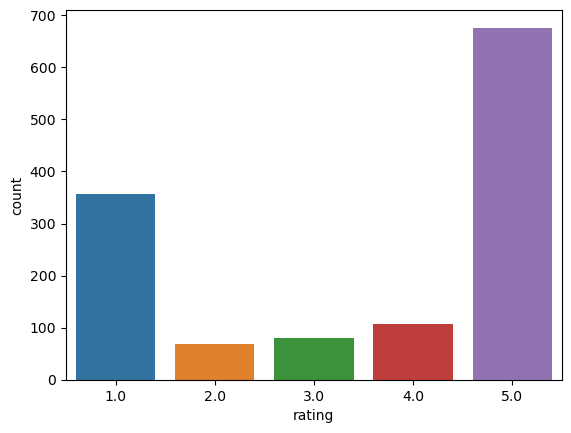

In [15]:
# Plotting the Class Distribution
sns.countplot(x=games_df['rating'])
plt.show()

#### Comments
As expected, 5 is the majority class because many people who review products are either in love with product and excited to share something about it, or the person hates the product and would like to share the problems  they had when trying to watch/read/play the product. Hence, 1 is the second most populated class. Meanwhile, the middle 3 classes (2, 3, & 4) are all miniscule (<100) compared to 1 (~350) and 5 (700). This class imbalance will have to addressed by implemented either downsampling or oversampling for the modeling phase. 

### Book Data Exploration

In [16]:
books_df.isna().sum()

name              3
movie_title       0
review_title      6
review          183
rating            0
date_place        0
dtype: int64

In [17]:
# Dropping Nulls
books_df = books_df.dropna()
books_df.shape

(104667, 6)

In [18]:
books_df.head(3)

,name,movie_title,review_title,review,rating,date_place
0,Haical Sajovic Haddad,Atomic Habits: An Easy & Proven Way to Build G...,Updated review after 100 days building small y...,I previously wrote this review right after rea...,5.0,"Reviewed in the United States on October 18, 2018"
1,Jim Muccio,Atomic Habits: An Easy & Proven Way to Build G...,Just Do It,"James Clear in his truly remarkable book, “Ato...",5.0,"Reviewed in the United States on December 24, ..."
2,Jocelyn Nielson,Atomic Habits: An Easy & Proven Way to Build G...,A must-read for people who want to create bett...,I’d like to say that I first bought this back ...,5.0,"Reviewed in the United States on May 31, 2023"


In [19]:
books_df['movie_title'].unique()

array(['Atomic Habits: An Easy & Proven Way to Build Good Habits & Break Bad Ones',
       'Brown Bear, Brown Bear, What Do You See?',
       'Central Park West: A Crime Novel',
       'Demon Copperhead: A Pulitzer Prize Winner',
       'First Grade, Here I Come!', 'Fourth Wing (The Empyrean, 1)',
       'Happy Place', 'Haunting Adeline (Cat and Mouse Duet)',
       'Icebreaker: A Novel (The Maple Hills Series)',
       'If He Had Been with Me', 'I Love You to the Moon and Back',
       'It Ends with Us: A Novel (1)',
       'It Starts with Us: A Novel (2) (It Ends with Us)',
       'I Will Teach You to Be Rich: No Guilt. No Excuses. Just a 6-Week Program That Works (Second Edition)',
       'Killers of the Flower Moon: The Osage Murders and the Birth of the FBI',
       'Kindergarten, Here I Come!', 'Lessons in Chemistry: A Novel',
       "Oh, the Places You'll Go!  ",
       'Outlive: The Science and Art of Longevity',
       'Read Me When You Need Me.',
       'Rich Dad Poor Dad: Wh

In [20]:
# Investigate different languages that make up the review text
books_df['lang'] = books_df['review'].apply(tf.detect_language)
books_df['lang'].value_counts()

en         100060
af            854
es            486
so            384
de            329
it            236
ro            229
fr            229
ca            208
pt            171
sl            169
da            163
ja            153
nl            144
tl            136
no            127
unknown        98
cy             88
et             73
hu             53
sv             50
sk             42
pl             32
sw             30
fi             23
id             23
vi             23
sq             21
hr             10
tr              9
cs              7
lt              6
lv              1
Name: lang, dtype: int64

In [21]:
# drop non english reviews
books_df = books_df.query('lang == "en"')

In [22]:
# Convert pandas series of reviews to a list in order to get stats on entire review text
books_texts = books_df['review'].tolist()
books_texts = " ".join(books_texts)
tf.descriptive_stats(books_texts)

There are 27540849 tokens in the data.
There are 1060 unique tokens in the data.
There are 27540849 characters in the data.
The lexical diversity is 0.000 in the data.
[(' ', 5028477), ('e', 2493635), ('t', 1968092), ('o', 1810900), ('a', 1650180)]


[27540849, 1060, 0.0, 27540849]

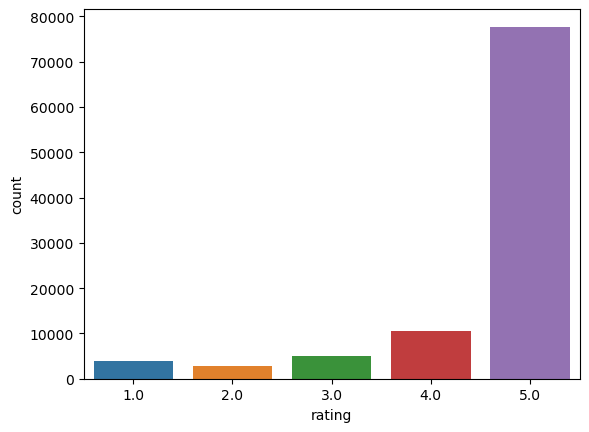

In [23]:
sns.countplot(x=books_df['rating'])
plt.show()

#### Comments
For books, the class imbalance is even more severe. The 5 class has around 80,000 reviews while the other 4 classes can hardly sum up to 10,000 reviews. It seems that consumers excitement about a book being good has overrun the review sections on Amazon. This is particularly supported by 4.0 being the second highest class. 

### Movie Data Exploration

In [24]:
movies_df.isna().sum()

name            0
movie_title     0
review_title    7
review          8
rating          0
date_place      0
dtype: int64

In [25]:
# Dropping Nulls
movies_df = movies_df.dropna()
movies_df.shape

(22876, 6)

In [26]:
movies_df.head(3)

,name,movie_title,review_title,review,rating,date_place
0,Not bad at all,2 Fast 2 Furious,Love this movie,Truly one of my faves. It’s a must watch if yo...,5.0,"Reviewed in the United States 🇺🇸 on May 11, 2023"
1,Coleman,2 Fast 2 Furious,Fast n furious,I LOVE ALL THEIR MOVIES LOL,5.0,"Reviewed in the United States 🇺🇸 on May 16, 2023"
2,Jack Pocock,2 Fast 2 Furious,American Masterpiece,If you didn't enjoy this movie--- you're wrong...,5.0,"Reviewed in the United States 🇺🇸 on April 28, ..."


In [27]:
movies_df['movie_title'].unique()

array(['2 Fast 2 Furious', 65, '80 For Brady', 'A Good Person',
       'A Man Called Otto', 'Avatar: The Way of Water', 'Champions',
       'Cocaine Bear', 'Creed III',
       'Dungeons & Dragons: Honor Among Thieves', 'Evil Dead Rise',
       'F9: The Fast Saga', 'Fifty Shades Darker',
       "Guy Ritchie's The Covenant", 'Jesus Revolution',
       'John Wick: Chapter 4 - Bonus X-Ray Edition',
       'John Wick: Chapter 4', 'Knock at the Cabin', 'Love Again',
       'M3GAN', "Magic Mike's Last Dance", 'Moving On',
       'Operation Fortune: Ruse de Guerre', 'Pitch Perfect 3', 'Plane',
       'Puss in Boots: The Last Wish', 'Renfield', 'Reunion, Pt. 2',
       'Scream VI', 'Shazam! Fury of the Gods', 'Sisu',
       'Spider-Man: Into the Spider-Verse', 'The Croods: A New Age',
       'The Fast and the Furious', "The Pope's Exorcist",
       'The Ritual Killer', 'The Super Mario Bros. Movie', 'The Whale'],
      dtype=object)

In [28]:
# Investigate different languages that make up the review text
movies_df['lang'] = movies_df['review'].apply(tf.detect_language)
movies_df['lang'].value_counts()

en         19792
af           676
de           285
ro           240
es           190
so           184
fr           161
sk           141
it           121
no           116
sl           111
ca           100
da            97
unknown       90
nl            87
cy            81
tl            63
et            59
sw            32
hu            30
id            30
ja            30
hr            28
pt            27
pl            18
fi            17
sv            17
tr            16
vi            16
sq            11
lt             5
lv             3
cs             2
Name: lang, dtype: int64

In [29]:
# drop non english reviews
movies_df = movies_df.query('lang == "en"')

In [30]:
# Convert pandas series of reviews to a list in order to get stats on entire review text
movies_texts = movies_df['review'].tolist()
movies_texts = " ".join(movies_texts)
tf.descriptive_stats(movies_texts)

There are 3449632 tokens in the data.
There are 251 unique tokens in the data.
There are 3449632 characters in the data.
The lexical diversity is 0.000 in the data.
[(' ', 630030), ('e', 315516), ('t', 248558), ('a', 211008), ('o', 207419)]


[3449632, 251, 0.0, 3449632]

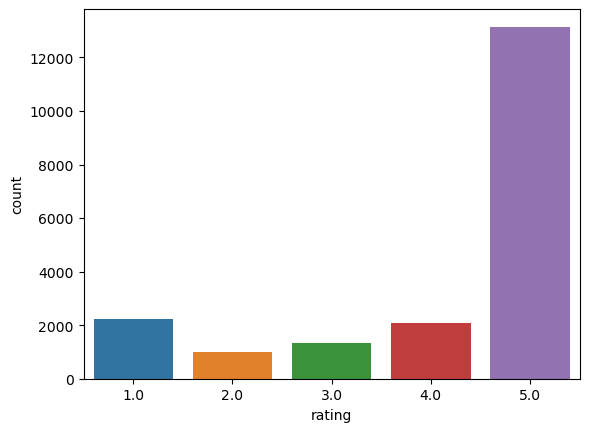

In [31]:
sns.countplot(x=movies_df['rating'])
plt.show()

#### Comments
Again for movies, the most positive class 5, by far has the most reviews. The second highest class is 1, similar to the games section, yet it is much closer to 4 than games was. This concludes the class investigation for all three media types; games, books, and movies. Moving forward into modeling, finding some way to create class balance will be necessary, especially as the model will be for sentiment with classes 1 + 2 being negative and classes 4 + 5 being positive. 

## Sentiment Modeling

### Prepping the data for modeling

In [32]:
# drop titles
nlp_df = combined_df.drop(columns=['game_title','movie_title'])

# drop values
nlp_df = nlp_df.dropna()

# drop non english reviews
nlp_df['lang'] = nlp_df['review'].apply(tf.detect_language)

nlp_df = nlp_df.query('lang == "en"')

# convert review from float to int
nlp_df['rating'] = nlp_df['rating'].astype(int)

In [33]:
nlp_df['review_tokens'] = nlp_df['review'].apply(tf.clean_tokenize)
nlp_df['review_title_tokens'] = nlp_df['review_title'].apply(tf.clean_tokenize)

In [34]:
nlp_df.groupby(['rating'])['review'].count()

rating
1     6475
2     3899
3     6465
4    12777
5    91528
Name: review, dtype: int64

In [35]:
# Creating Binary Sentiment Class
nlp_df['sentiment'] = 0
nlp_df.loc[nlp_df['rating']>3, 'sentiment'] = 1
nlp_df.loc[nlp_df['rating']<3, 'sentiment'] = 0

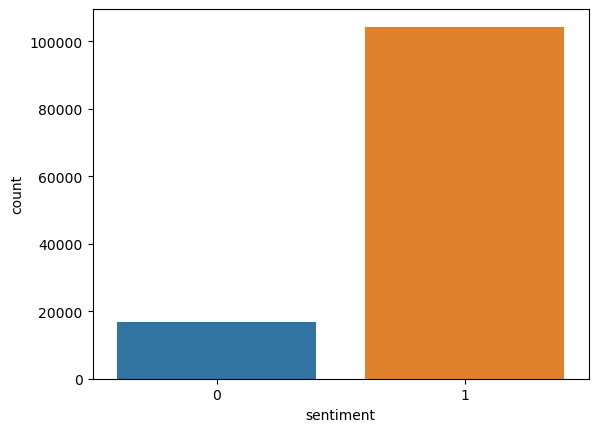

In [36]:
# Combined DataFrame Sentiment Counts
sns.countplot(x=nlp_df['sentiment'])
plt.show()

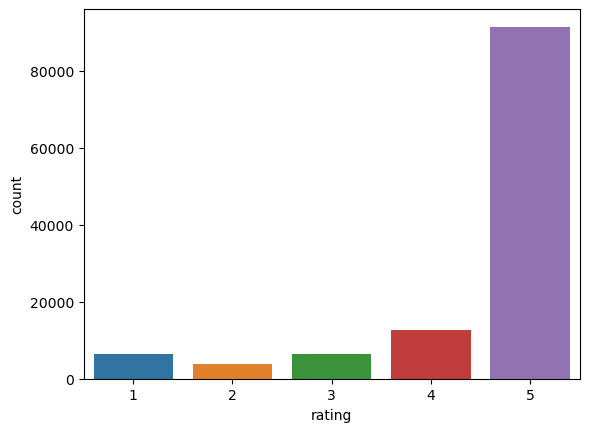

In [37]:
# Combined DataFrame Rating Counts
sns.countplot(x=nlp_df['rating'])
plt.show()

#### Comments
The massive class 5 imbalance throughout each media type has also led to a massive sentiment imbalance in the entire dataset. Below, the class imbalance will be addressed by implementing downsampling to address these concerns. 5 will be downsamples to be equal to the other 4 classes combined. 

In [38]:
# All non-5 Classes
no_5 = nlp_df.query('rating != 5')

# Just 5 Class
just_5 = nlp_df.query('rating == 5')

In [39]:
# Resampling Class 5 to 15,000
adjusted_5 = resample(just_5,
                      replace=False,
                      n_samples=15000,
                      random_state=10)

In [40]:
# Creating Downsampled DataFrame for modeling
adj_nlp_df = pd.concat([adjusted_5, no_5])

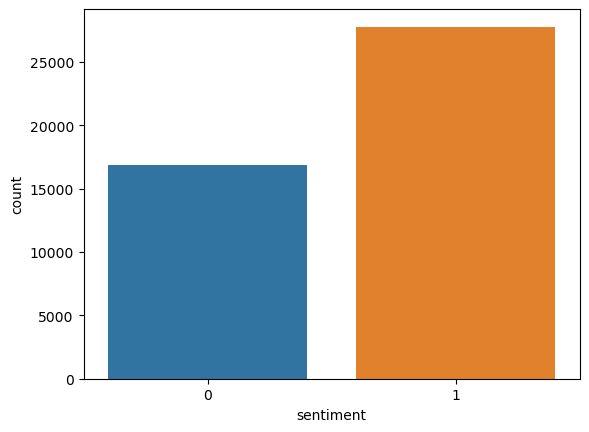

In [41]:
sns.countplot(x=adj_nlp_df['sentiment'])
plt.show()

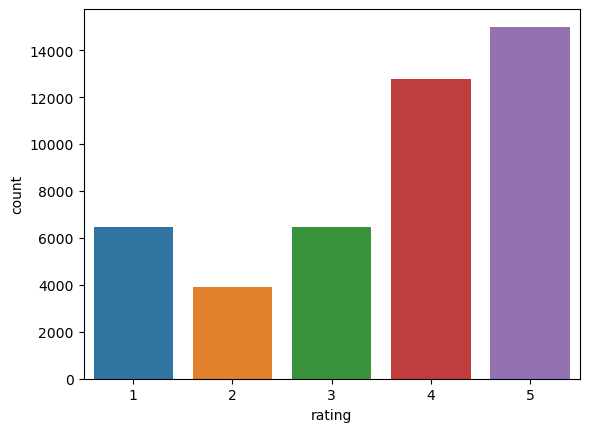

In [42]:
sns.countplot(x=adj_nlp_df['rating'])
plt.show()

#### Comments
Looking at the final dataframe, there is still a slight bias towards class 5 and 1 sentiment in terms of overall volume, but it will be much more manageable moving forward without removing a sizeable amount more of data that can potentially be used for modeling. 

### Splitting the Data

In [43]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(adj_nlp_df['review'], adj_nlp_df['sentiment'], test_size=0.20, random_state=10, stratify=adj_nlp_df['sentiment'])

In [44]:
# General stats from custom function file
tf.sentiment_stats(X_train, X_test, y_train, y_test)

Size of Training Data  35692
Size of Test Data  8924
Distribution of classes in Training Data :
Positive Sentiment  62.25764877283425
Negative Sentiment  37.74235122716575
Distribution of classes in Testing Data :
Positive Sentiment  62.25907664724338
Negative Sentiment  37.74092335275661


### Vectorize the Data

In [45]:
# tfidf vectorization of the data for model input
tfidf = TfidfVectorizer(min_df = 20, max_df=.2 ,ngram_range=(1,1),stop_words=sw)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)
X_train_tf.shape

(35692, 4514)

### Train SVC Model

In [46]:
# Training model
svc_model = LinearSVC(random_state=10, tol=1e-5)
svc_model.fit(X_train_tf, y_train)

LinearSVC(random_state=10, tol=1e-05)

In [47]:
# Predicting Test Set
y_pred = svc_model.predict(X_test_tf)

print ('Accuracy Score - ', accuracy_score(y_test, y_pred))
print ('Precision - ', precision_score(y_test, y_pred, average='macro'))
print ('Recall - ', recall_score(y_test, y_pred, average='macro'))
print ('F1 Score - ', f1_score(y_test, y_pred, average='macro'))

Accuracy Score -  0.8352756611385029
Precision -  0.8257017514276721
Recall -  0.8220507798806025
F1 Score -  0.8237723002944033


### Train Pytorch Model

In [48]:
# Prepping for Bert Tokenization
config = BertConfig.from_pretrained('bert-base-uncased',finetuning_task='binary')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
# Building Tokens from Bert
X_train_tokens = X_train.apply(tf.get_tokens, args=(tokenizer, 50))
X_test_tokens = X_test.apply(tf.get_tokens, args=(tokenizer, 50))

In [50]:
# Building tensors and tensor dataset for model input
input_ids_train = torch.tensor([features[0] for features in X_train_tokens.values], dtype=torch.long)
input_mask_train = torch.tensor([features[1] for features in X_train_tokens.values], dtype=torch.long)
label_ids_train = torch.tensor(y_train.values, dtype=torch.long)
train_dataset = TensorDataset(input_ids_train, input_mask_train, label_ids_train)

In [51]:
# Building tensors and tensor dataset for model input
input_ids_test = torch.tensor([features[0] for features in X_test_tokens.values],dtype=torch.long)
input_mask_test = torch.tensor([features[1] for features in X_test_tokens.values],dtype=torch.long)
label_ids_test = torch.tensor(y_test.values,dtype=torch.long)
test_dataset = TensorDataset(input_ids_test, input_mask_test, label_ids_test)

In [52]:
# Setting model Parameters For Model
train_batch_size = 64
num_train_epochs = 2
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,sampler=train_sampler,batch_size=train_batch_size)
t_total = len(train_dataloader) // num_train_epochs
print ("Num examples = ", len(train_dataset))
print ("Num Epochs = ", num_train_epochs)
print ("Total train batch size = ", train_batch_size)
print ("Total optimization steps = ", t_total)

Num examples =  35692
Num Epochs =  2
Total train batch size =  64
Total optimization steps =  279


In [ ]:
# Setting model HyperParameters
learning_rate = 1e-4
adam_epsilon = 1e-8
warmup_steps = 0

# Using Adam Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=warmup_steps,num_training_steps=t_total)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iterator = trange(num_train_epochs, desc="Epoch")

# Put model in 'train' mode
model.train()
for epoch in train_iterator:
    epoch_iterator = notebook.tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
        # Reset all gradients at start of every iteration
        model.zero_grad()
        # Put the model and the input observations to GPU
        model.to(device)
        batch = tuple(t.to(device) for t in batch)
        # Identify the inputs to the model
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        # Forward Pass through the model. Input -> Model -> Output
        outputs = model(**inputs)
        # Determine the deviation (loss)
        loss = outputs[0]
        print("\r%f" % loss, end='')
        # Back-propogate the loss (automatically calculates gradients)
        loss.backward()
        # Prevent exploding gradients by limiting gradients to 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update the parameters and learning rate
        optimizer.step()
        scheduler.step()

# Save trained model
model.save_pretrained('../models/torch_outputs')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/558 [00:00<?, ?it/s]

0.269984

Epoch:  50%|█████     | 1/2 [1:22:17<1:22:17, 4937.06s/it]

Iteration:   0%|          | 0/558 [00:00<?, ?it/s]

0.220635

Epoch: 100%|██████████| 2/2 [2:44:10<00:00, 4925.31s/it]  


In [55]:
test_batch_size = 64
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset,
                             sampler=test_sampler,
                             batch_size=test_batch_size)

# Load the pre-trained model if needed
# model = model.from_pretrained('/outputs')

# Initialize the prediction and actual labels
preds = None
out_label_ids = None

## Put model in "eval" mode
model.eval()

for batch in notebook.tqdm(test_dataloader, desc="Evaluating"):

    ## Put the model and the input observations to GPU
    model.to(device)
    batch = tuple(t.to(device) for t in batch)

    ## Do not track any gradients since in 'eval' mode
    with torch.no_grad():
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        ## Forward pass through the model
        outputs = model(**inputs)

        ## We get loss since we provided the labels
        tmp_eval_loss, logits = outputs[:2]

        ## There maybe more than one batch of items in the test dataset
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids,
                                      inputs['labels'].detach().cpu().numpy(),
                                      axis=0)

## Get final loss, predictions and accuracy
preds = np.argmax(preds, axis=1)
acc_score = accuracy_score(preds, out_label_ids)
print ('Accuracy Score on Test data ', acc_score)

Evaluating:   0%|          | 0/140 [00:00<?, ?it/s]

Accuracy Score on Test data  0.867996414164052


## Sample Predictions

### SVC Model

In [56]:
sample_reviews = nlp_df.sample(5)
sample_reviews_tf = tfidf.transform(sample_reviews['review'])
sentiment_predictions = svc_model.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['review','sentiment_prediction']]

Some sample reviews with their sentiment - 


,review,sentiment_prediction
79207,I loved it. It was Addictive. I couldn’t leave...,1
109300,Silly but funny in a dark comedy way,0
2708,Atomic Habits provides the actionable ground w...,1
70554,This book did not go the way I was expecting A...,1
72530,this book kept me going for days. definitely a...,1


In [57]:
text = ['This game is okay']
test = tfidf.transform(text)
test_pred = svc_model.predict(test)

test_pred

array([0], dtype=int64)

### Pytorch Model

In [58]:
# Preprocess the sample review
sample_review = "This game is good"


# Convert preprocessed text to PyTorch tensors
input_ids, attention_mask = tf.get_tokens(sample_review, tokenizer, 50)
input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0)  # Assuming batch size of 1
attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0)  # Assuming batch size of 1


# Make the prediction
model.eval()
with torch.no_grad():
    input_tensor = input_tensor.to(device)
    attention_mask_tensor = attention_mask_tensor.to(device)
    outputs = model(input_ids=input_tensor, attention_mask=attention_mask_tensor)
    predicted_class = torch.argmax(outputs.logits, dim=1)

print("Predicted class:", predicted_class.item())

Predicted class: 1


c:\Users\whitm\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#### Selecting a Final Model

While the accuracy for the Pytorch model came out to be slightly higher at 86% while the SVC had an accuracy of around 83%. Due to the complexity and training time (nearly 2 1/2 hours of training) of the pytorch model, the team ultimately decided that the SVC would best fit our needs throughout deployment despite the slight reduction in accuracy. 

### Saving Pickle Models

The pickle models will be used for deployment in the API.

In [59]:
with open('../models/svc_model.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

with open('../models/tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

## Topic Modeling

### Formulas for Topic Modeling

In [60]:
# To Display Topic Words
def display_topics(model, features, no_top_words=5):
    # Looping Through the Topic and the Words
    for topic, words in enumerate(model.components_):
        total = words.sum()
        # invert sort order
        largest = words.argsort()[::-1] 
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

### Preparing the Data

As Topic Modeling is an unsupervised learning method, the entire dataset will be used to transform the model. 

In [62]:
adj_nlp_df.head()

,name,review_title,review,rating,date_place,lang,review_tokens,review_title_tokens,sentiment
54546,Adam marcus,BY FAR THE BEST BOOK I'VE EVER READ,BY FAR THE BEST BOOK I'VE EVER READ. I RECOMME...,5,"Reviewed in the United States on January 3, 2017",en,"[far, best, book, ive, ever, read, recommend, ...","[far, best, book, ive, ever, read]",1
45998,tay,Very informative book,I like how descriptive you get about the disti...,5,"Reviewed in the United States on June 19, 2021",en,"[like, descriptive, get, distinct, differences...","[informative, book]",1
23941,Elizabeth,Loved it,"I loved it! Finished this book in two days, so...",5,"Reviewed in the United States on March 5, 2022",en,"[loved, finished, book, two, days, hooked]",[loved],1
85333,Ashley,This is one of my 18 month old's favorite book...,This is one of my 18 month old's favorite book...,5,"Reviewed in the United States on September 1, ...",en,"[one, 18, month, olds, favorite, books, moment...","[one, 18, month, olds, favorite, books, moment]",1
1868,Melanie,Amazing!,A classic!!!,5,"Reviewed in the United States on April 10, 2022",en,[classic],[amazing],1


In [65]:
# vectorizing the review data for topic modelling
# count vectorizing for the LDA model
count = CountVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_count_vectors = count.fit_transform(adj_nlp_df['review'])

#TFIDF vectorizing for NMF and SVD Models
idf = TfidfVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_tfidf_vectors = idf.fit_transform(adj_nlp_df['review'])

### NMF

In [66]:
# create model
nmf_text_model = NMF(n_components=2, random_state=33)

# fit model
nmf_text_matrix = nmf_text_model.fit_transform(X_tfidf_vectors)
c_text_matrix = nmf_text_model.components_

In [67]:
# displaying the top 10 results
display_topics(nmf_text_model, idf.get_feature_names_out(), 10)


Topic 00
  book (2.14)
  read (1.41)
  good (0.86)
  love (0.69)
  one (0.67)
  story (0.67)
  like (0.58)
  really (0.50)
  reading (0.50)
  loved (0.46)

Topic 01
  great (12.55)
  movie (12.30)
  watch (2.00)
  family (1.86)
  kids (1.45)
  good (1.34)
  funny (1.09)
  love (0.98)
  loved (0.70)
  watching (0.65)


#### Comments
Looking at our separation here, the model has not separated the topics by sentiment, as we have done in our classification models, and instead separated the two topics by postive book reviews and positive movie reviews. This can still be insightful to see the differences between the two mediums. For instance, as expected the movies topics includes watching while the book topic includes reading and read. Additionally, the movie topic includes family and kids while the book topic does not. This is likely due to the nature of movies having the potential to be a group activity for a family to come together and watch something for 2 hours. Additionally, movies includes funny prominently likely because the comedy genre is more popular in movies than for books. 

### SVD

In [68]:
svd_text_model = TruncatedSVD(n_components=2, random_state=33)
svd_text_matrix = svd_text_model.fit_transform(X_tfidf_vectors)
csvd_text_matrix = svd_text_model.components_

In [69]:
display_topics(svd_text_model, idf.get_feature_names_out(), 10)


Topic 00
  book (2.04)
  read (1.32)
  great (1.05)
  good (0.91)
  love (0.72)
  story (0.67)
  one (0.63)
  movie (0.63)
  like (0.56)
  really (0.50)

Topic 01
  movie (24.22)
  great (17.20)
  watch (3.84)
  family (3.37)
  kids (2.49)
  funny (1.97)
  good (1.91)
  watching (1.24)
  movies (1.14)
  action (1.08)


#### Comments
Again it looks like the topic has been separated into movie and book. The book topic did have movie leak over into it. Interestingly the book topic includes love, potentially due to the romance genre being so popular, while the movie topic includes action, funny, family, and kids due to the genre difference and nature between the two topics. 

### LDA

In [70]:
lda_text_model = LatentDirichletAllocation(n_components=2, random_state=33)
lda_text_model.fit(X_count_vectors)
lda_text_matrix = lda_text_model.transform(X_count_vectors)
clda_text_matrix = lda_text_model.components_

In [71]:
display_topics(lda_text_model, count.get_feature_names_out(), 10)


Topic 00
  book (4.84)
  read (2.42)
  story (1.53)
  love (1.10)
  one (1.03)
  like (0.97)
  good (0.86)
  reading (0.74)
  characters (0.72)
  really (0.71)

Topic 01
  book (1.78)
  movie (1.50)
  good (0.83)
  like (0.77)
  one (0.75)
  great (0.69)
  would (0.57)
  people (0.54)
  life (0.54)
  get (0.49)


In [74]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, X_count_vectors, count, sort_topics=False)

In [75]:
pyLDAvis.display(lda_display)

#### Comments
Similar to the SVD the LDA had more leakage than the NMF model, with 'book' leaking into the movie topic. Although, this could potentially be explained by people comparing a movie based on a book to the book. An interesting word that appears in the book topic is characters. As books are more focused on characters, their development, and their perspectives, it makes sense that people would be more likely to discuss the characters in their reviews. The distance map shows that dimensionally the two groups are quite far apart. This adds up as the only real overlap is book, like, and good. Interestingly, the third media type, game did make it into the movie group. considering the visual aspect of both mediums, it does make sense they would be more closely aligned. 


### Pickle Model For Topic Modeling

In [76]:
# Saving the count vectorizer for the API
with open('../models/count_vect.pkl', 'wb') as file:
    pickle.dump(count, file)

## Future Enhancements

As the project has been limited to the top 50 games, books, and movies on Amazon, overall the project is limited by successful projects. If there were enough time to scrape more products to include more unsuccessful projects that had average ratings that were negative, there would be more natural balancing on the project. Additionally, it would provide more sentiment for products that are truly hated on average. 

If there were more products that had lower scores by average, the project could also attempt to classify the actual rating assigned to each review. With the immense bias for the 5 class, attempts at multiclass classification, even with downsampling, did struggle to make predictions. 